In [1]:
import pandas as pd
import numpy as np
import scipy
import matplotlib.pyplot as plt
from tqdm import tqdm

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import pymc3 as pm
import arviz as az
import seaborn as sns

https://archive.ics.uci.edu/ml/datasets/Energy+efficiency
X1 Relative Compactness
X2 Surface Area
X3 Wall Area
X4 Roof Area
X5 Overall Height
X6 Orientation
X7 Glazing Area
X8 Glazing Area Distribution
y1 Heating Load
y2 Cooling Load
y_ordered

In [2]:
data = pd.read_csv('data.csv')

Make target variable Y1 categorical.

In [3]:
y_ord = np.array([-1] * len(data))
a = (0.0, 0.2, 0.4, 0.6, 0.8, 1.0)
quants = np.quantile(data['Y1'], a)
for i, q in enumerate(quants[:-1]):
    y_ord[data['Y1'] >= q] = i
data['Y_ord'] = y_ord
data.insert(0, 'X0', [1] * data.shape[0])

In [4]:
data

,X0,X1,X2,X3,X4,X5,X6,X7,X8,Y1,Y2,Y_ord
0,1,0.98,514.5,294.0,110.25,7.0,2,0.0,0,15.55,21.33,2
1,1,0.98,514.5,294.0,110.25,7.0,3,0.0,0,15.55,21.33,2
2,1,0.98,514.5,294.0,110.25,7.0,4,0.0,0,15.55,21.33,2
3,1,0.98,514.5,294.0,110.25,7.0,5,0.0,0,15.55,21.33,2
4,1,0.90,563.5,318.5,122.50,7.0,2,0.0,0,20.84,28.28,2
...,...,...,...,...,...,...,...,...,...,...,...,...
763,1,0.64,784.0,343.0,220.50,3.5,5,0.4,5,17.88,21.40,2
764,1,0.62,808.5,367.5,220.50,3.5,2,0.4,5,16.54,16.88,2
765,1,0.62,808.5,367.5,220.50,3.5,3,0.4,5,16.44,17.11,2
766,1,0.62,808.5,367.5,220.50,3.5,4,0.4,5,16.48,16.61,2


Keep only first five features (delete categorical features). Add feature equals 1 for bias.

In [5]:
# X = data[data.columns[:9]].values
X = data[['X0', 'X1', 'X2', 'X3', 'X4', 'X5']].values
y = data['Y_ord'].values
n_classes = len(quants) - 1
n_feas = 6

Split data by train and test for comparison with non-bayes model. 

In [6]:
X_train, X_test, y_train, y_test = train_test_split(
                                                    X, y,
                                                    stratify=y, 
                                                    test_size=0.5
                                                )

Normalize features.

In [7]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

Bayes softmax regression.

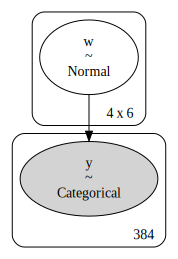

In [8]:
import theano.tensor as tt

with pm.Model() as model:
    w = pm.Normal(
        'w', mu=0, sd=2, 
        shape=(n_classes-1, n_feas)
    )
    mu = tt.concatenate([
        pm.math.dot(X_train, w.T),
        np.zeros((X_train.shape[0], 1))], axis=-1)
    outputs = pm.Categorical('y', tt.nnet.softmax(mu), observed=y_train)
    
pm.model_to_graphviz(model)

![title](diag.png)

Chains sampling.

In [9]:
n_chains = 2

with model:
    trace = pm.sample(
        draws=1000, tune=1000, chains=n_chains,
        cores=1, return_inferencedata=True
    )

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [w]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 49 seconds.


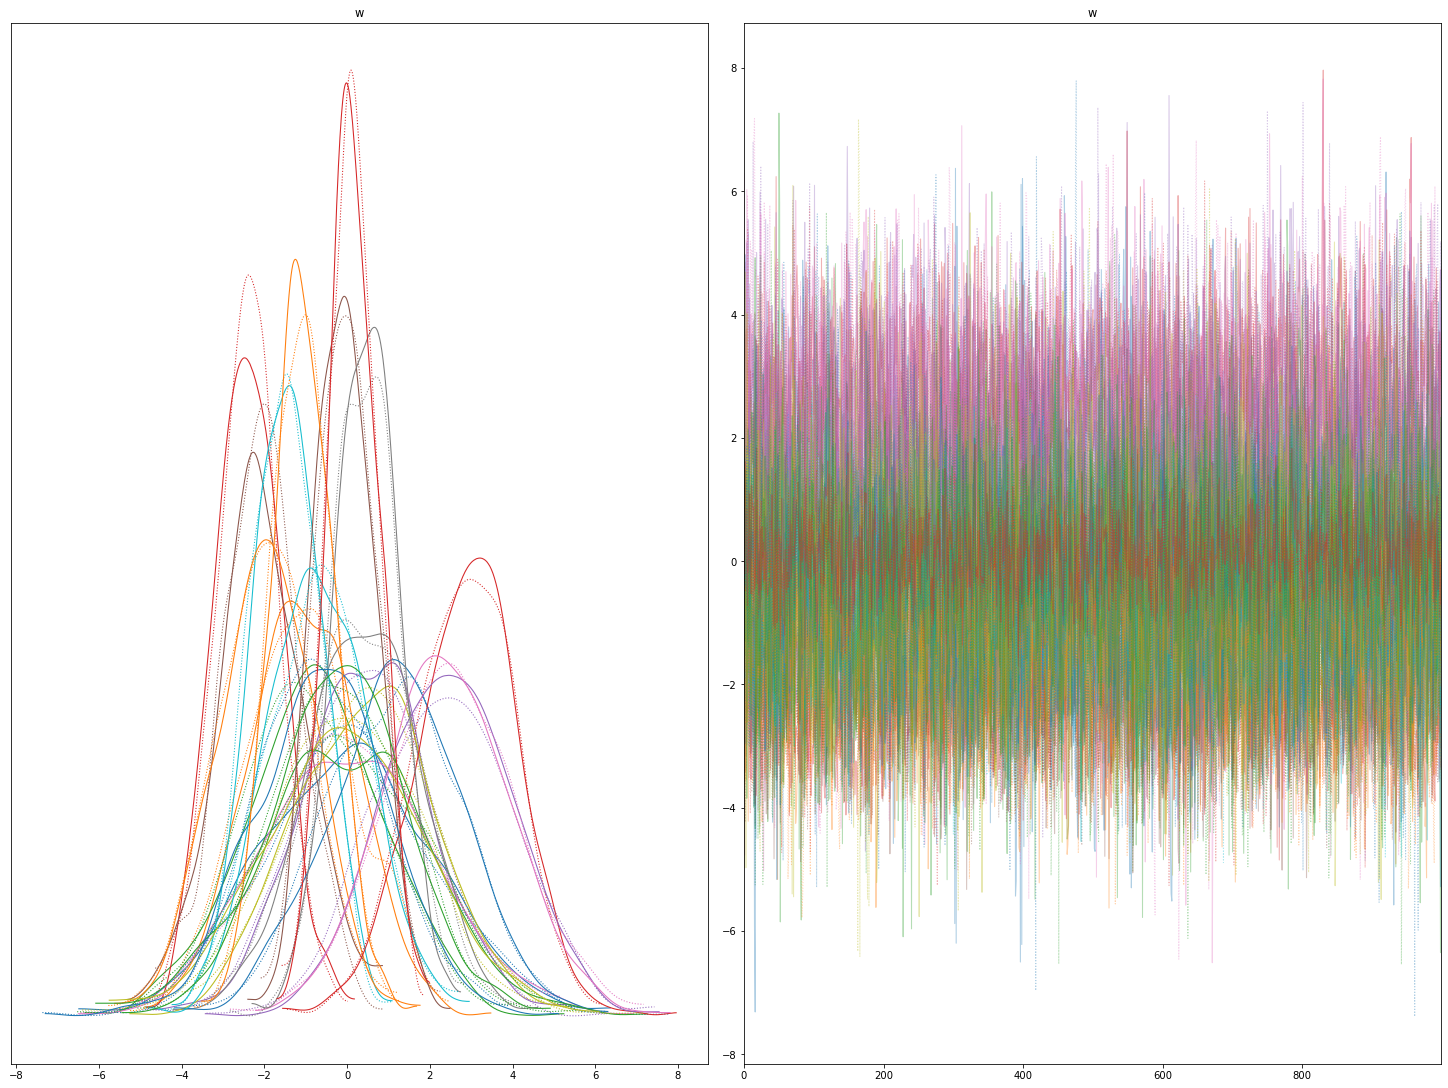

In [10]:
az.plot_trace(trace, figsize=(20, 15));

In [11]:
trace.posterior['w'].shape

(2, 1000, 4, 6)

Series look stationary with same means for different chains.

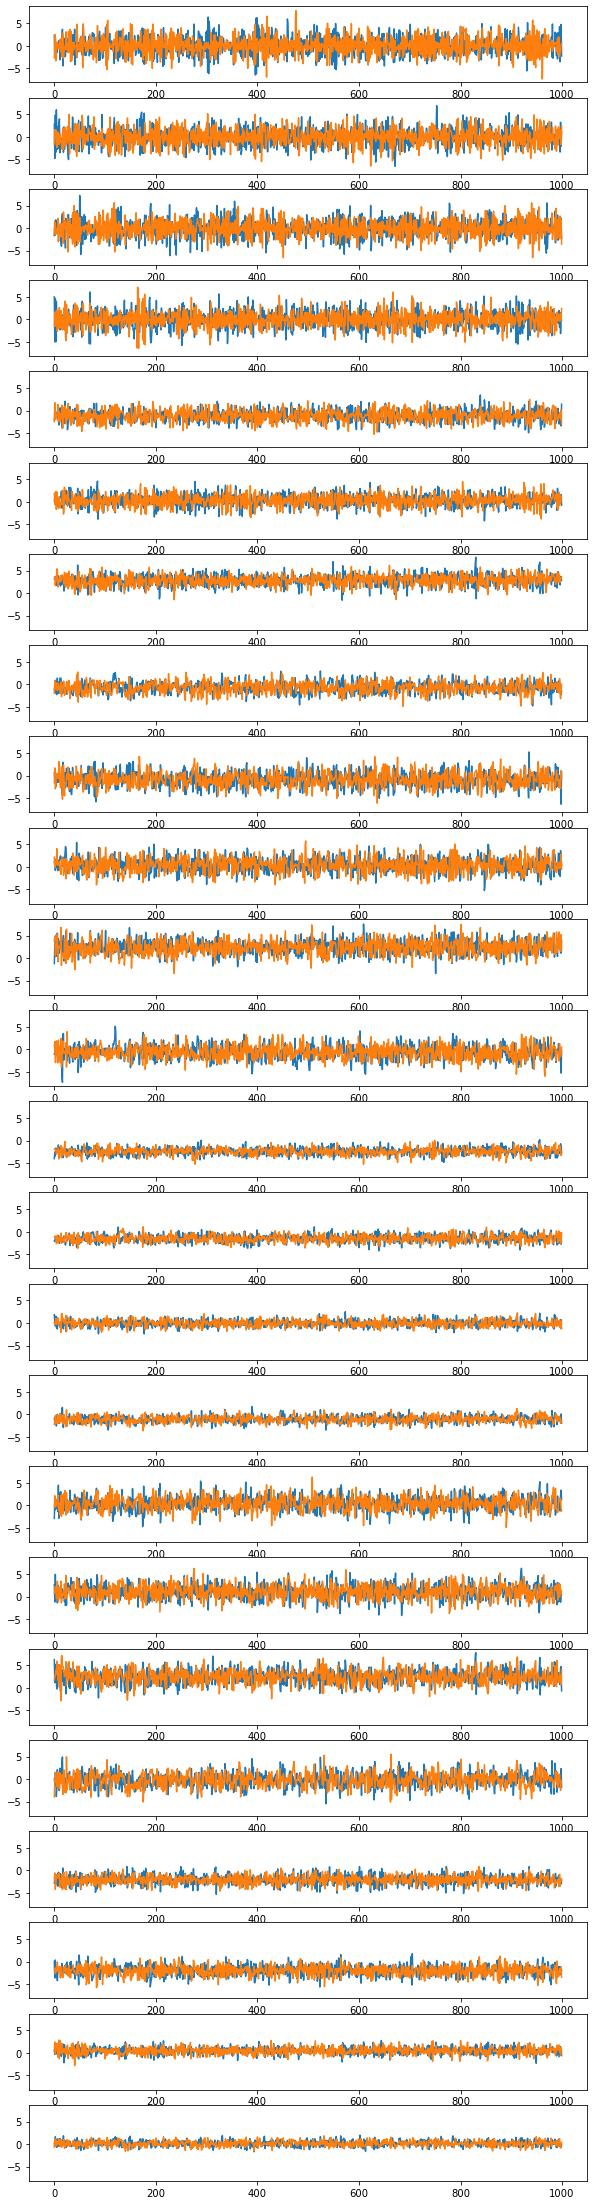

In [12]:
f, ax = plt.subplots(n_feas*(n_classes-1), 1, sharey=True, figsize=(10, 40))

for i in range(n_feas):
    for k in range(n_classes-1):
        for j in range(n_chains):
            ax[i*(n_classes-1) + k].plot(trace.posterior['w'][j,:,k,i])

Low autocorrelation.

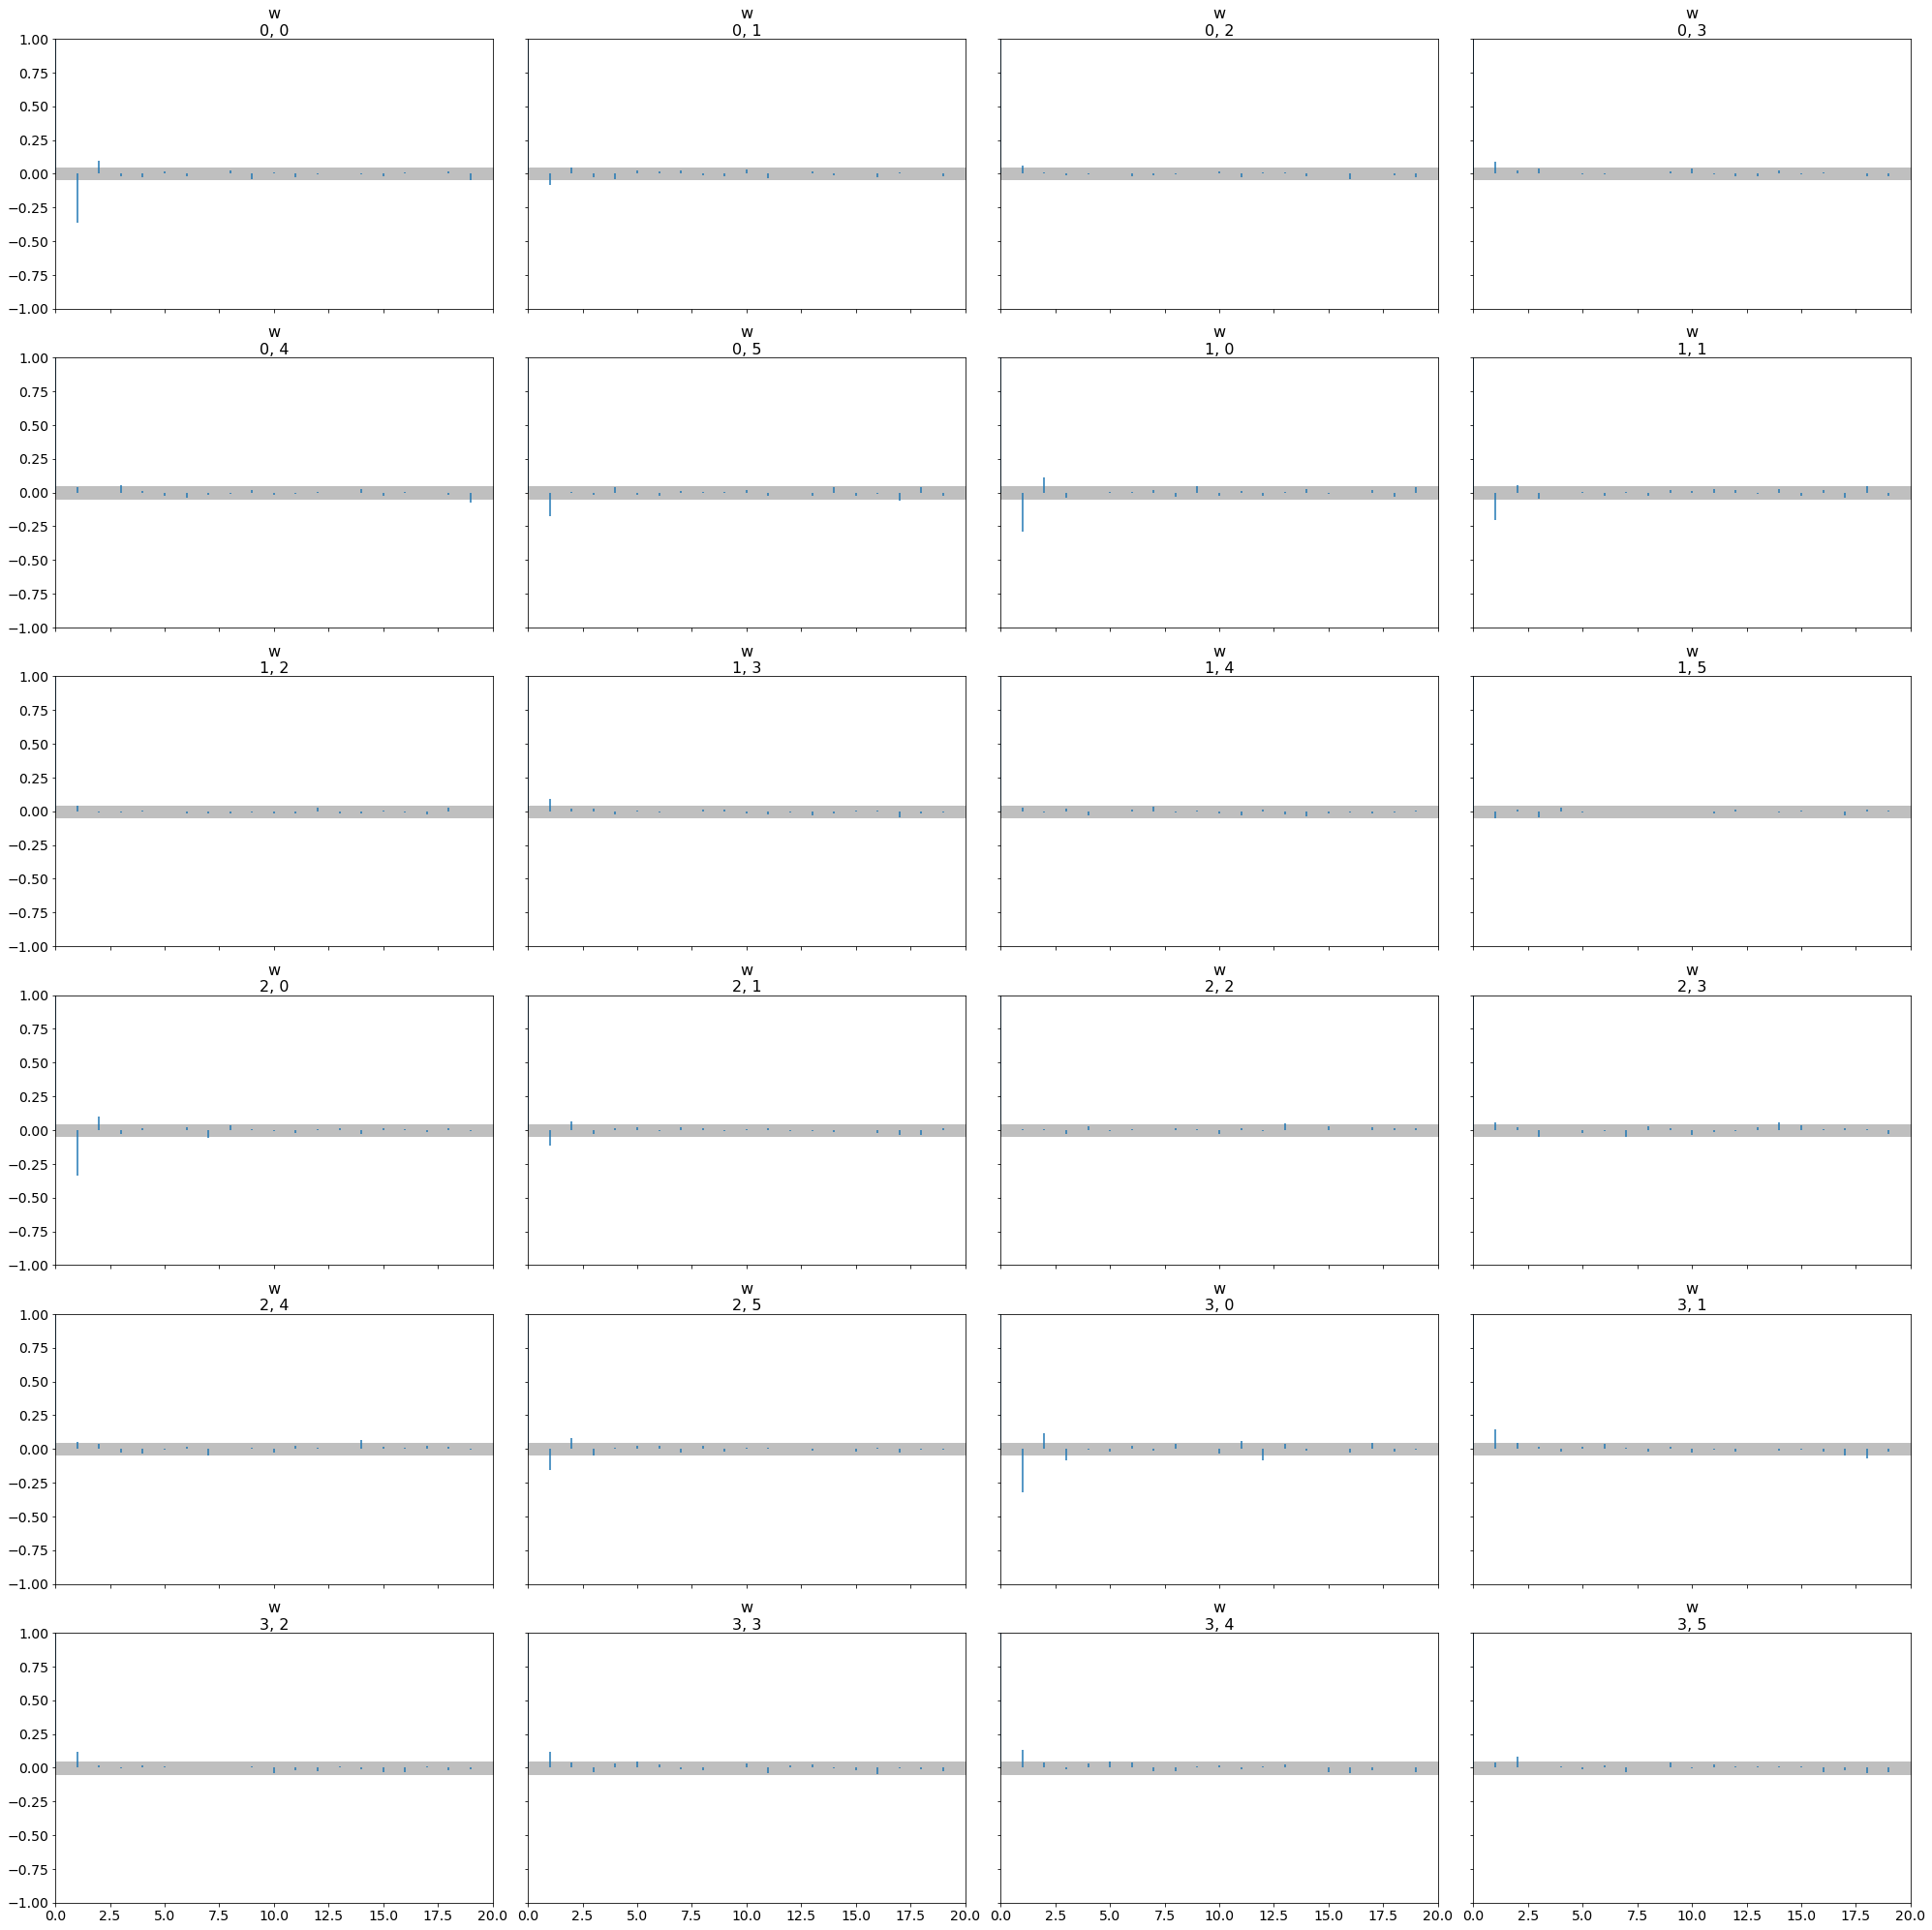

In [13]:
az.plot_autocorr(trace, max_lag=20, combined=True);

Same means for different chains and r_hat = 1.0 for all weights.

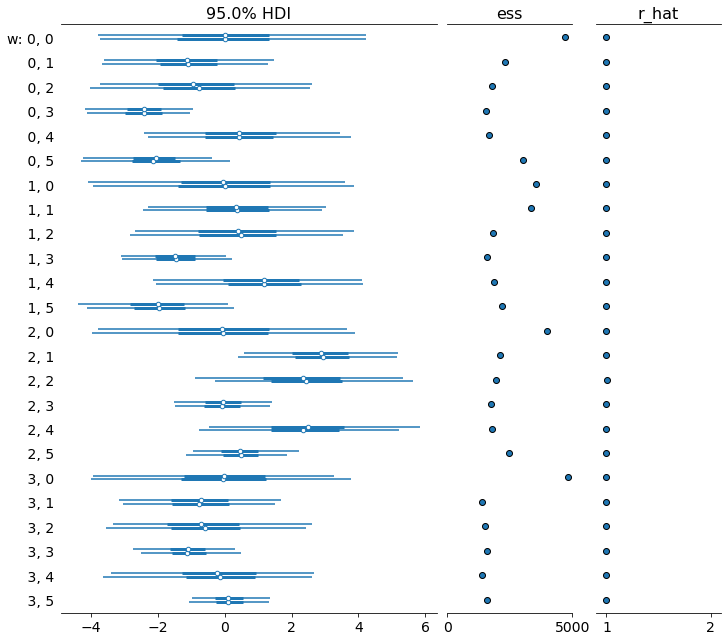

In [14]:
az.plot_forest(trace, hdi_prob=0.95,
               r_hat=True, ess=True);

In [15]:
az.summary(trace)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
"w[0,0]",0.012,2.070,-3.796,3.865,0.030,0.057,4817.0,1444.0,1.0
"w[0,1]",-1.106,1.309,-3.471,1.407,0.027,0.022,2349.0,1597.0,1.0
"w[0,2]",-0.819,1.656,-3.777,2.449,0.039,0.032,1794.0,1491.0,1.0
"w[0,3]",-2.417,0.805,-3.965,-0.920,0.020,0.015,1545.0,1529.0,1.0
"w[0,4]",0.443,1.558,-2.418,3.310,0.038,0.030,1672.0,1409.0,1.0
"w[0,5]",-2.081,1.023,-4.120,-0.165,0.018,0.014,3058.0,1325.0,1.0
"w[1,0]",0.003,2.001,-3.620,3.868,0.033,0.045,3584.0,1469.0,1.0
"w[1,1]",0.352,1.365,-2.191,2.903,0.023,0.027,3141.0,1791.0,1.0
"w[1,2]",0.414,1.668,-2.757,3.540,0.039,0.035,1846.0,1608.0,1.0
"w[1,3]",-1.478,0.847,-3.079,0.035,0.021,0.015,1590.0,1133.0,1.0


In [16]:
w = np.concatenate(trace.posterior['w'])

In [17]:
probs = X_test.dot(np.transpose(w, (0, 2, 1)))

Bayes predictions for test.

In [18]:
preds = probs.mean(1)
preds = np.concatenate([preds, np.zeros((X_test.shape[0], 1))], axis=1)
preds = scipy.special.softmax(preds, axis=1)
preds = preds.argmax(1)

In [30]:
# np.concatenate([
#     preds.reshape(-1, 1),
#     y_test.reshape(-1, 1)
# ], axis=1)

Accuracy. > 0.2 (for constant or random clasiffier)

In [20]:
(preds == y_test).sum() / y_test.shape[0]

0.5572916666666666

Non-bayes softmax regression.

In [21]:
def fit(X, y, lr, c, epochs):
    m, n = X.shape
    
    w = np.random.random((n, c-1))
    losses = []
    
    for epoch in range(epochs):
        z = X@w
        z = np.concatenate([z, np.zeros((m, 1))], axis=1)
        y_hat = scipy.special.softmax(z, axis=1)
        
        y_hot = np.zeros((m, c))
        y_hot[np.arange(len(y)),y] = 1
        
        w_grad = (1/m)*np.dot(X.T, (y_hat - y_hot)) 
        
        w = w - lr*w_grad[:,:-1]
        
        loss = -np.mean(np.log(y_hat[np.arange(len(y)), y]))
        losses.append(loss)
        # Printing out the loss at every 100th iteration.
        if epoch%100==0:
            print('Epoch {epoch}==> Loss = {loss}'
                  .format(epoch=epoch, loss=loss))
    return w

In [22]:
w_02 = fit(X_train, y_train, 0.05, n_classes, 3000)

Epoch 0==> Loss = 1.773618447185714
Epoch 100==> Loss = 1.1782187432356863
Epoch 200==> Loss = 1.1106976664700323
Epoch 300==> Loss = 1.0777347079803026
Epoch 400==> Loss = 1.0586487525266937
Epoch 500==> Loss = 1.0462550821463656
Epoch 600==> Loss = 1.0375106534280183
Epoch 700==> Loss = 1.0309734107748485
Epoch 800==> Loss = 1.0258909986797267
Epoch 900==> Loss = 1.0218330139750884
Epoch 1000==> Loss = 1.01853151326797
Epoch 1100==> Loss = 1.0158074507214943
Epoch 1200==> Loss = 1.0135345031170642
Epoch 1300==> Loss = 1.0116199742794068
Epoch 1400==> Loss = 1.009993925989483
Epoch 1500==> Loss = 1.008602523619803
Epoch 1600==> Loss = 1.0074036976129703
Epoch 1700==> Loss = 1.0063641724782768
Epoch 1800==> Loss = 1.0054573580573756
Epoch 1900==> Loss = 1.0046618141720167
Epoch 2000==> Loss = 1.003960111918989
Epoch 2100==> Loss = 1.0033379771615654
Epoch 2200==> Loss = 1.0027836388357698
Epoch 2300==> Loss = 1.002287328123575
Epoch 2400==> Loss = 1.0018408900671048
Epoch 2500==> Loss 

In [23]:
w_02.shape

(6, 4)

In [24]:
probs_02 = X_test.dot(w_02)

Non-bayes predictions for test.

In [25]:
preds_02 = probs_02
preds_02 = np.concatenate([preds_02, np.zeros((X_test.shape[0], 1))], axis=1)
preds_02 = scipy.special.softmax(preds_02, axis=1)
preds_02 = preds_02.argmax(1)

In [31]:
# np.concatenate([
#     preds_02.reshape(-1, 1),
#     y_test.reshape(-1, 1)
# ], axis=1)

Accuracy. > 0.2 (for constant or random clasiffier) and > 0.557 (for bayes classifier).

In [27]:
(preds_02 == y_test).sum() / y_test.shape[0]

0.5807291666666666